This shows how to classify from images. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

It follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Image classification

## Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data.

In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [22]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
#print("GPU Available:", tf.test.is_gpu_available())
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Begin by downloading the dataset. This lab uses a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from Kaggle. Download the archive version of the dataset and store it in the "/tmp/" directory.

In [24]:
import zipfile

# URL of the dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Define custom download and extraction path
download_dir = os.path.join(os.getcwd(), 'data')  # You can customize this
os.makedirs(download_dir, exist_ok=True)

# Step 1: Download the zip file to custom directory
zip_path = tf.keras.utils.get_file(
    'cats_and_dogs_filtered.zip',
    origin=_URL,
    extract=False,  # We'll extract manually
    cache_dir=download_dir
)

# Step 2: Extract the zip file manually to your desired location
extract_dir = os.path.join(download_dir, 'cats_and_dogs_filtered')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(download_dir)

print("Dataset extracted to:", extract_dir)

Dataset extracted to: /content/data/cats_and_dogs_filtered


The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [25]:
train_dir = os.path.join(extract_dir, 'train')
validation_dir = os.path.join(extract_dir, 'validation')

In [26]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understand the data

Let's look at how many cats and dogs images are in the training and validation directory:

In [27]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [28]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [29]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [30]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [31]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [32]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [33]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [34]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 2, figsize=(6,6))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

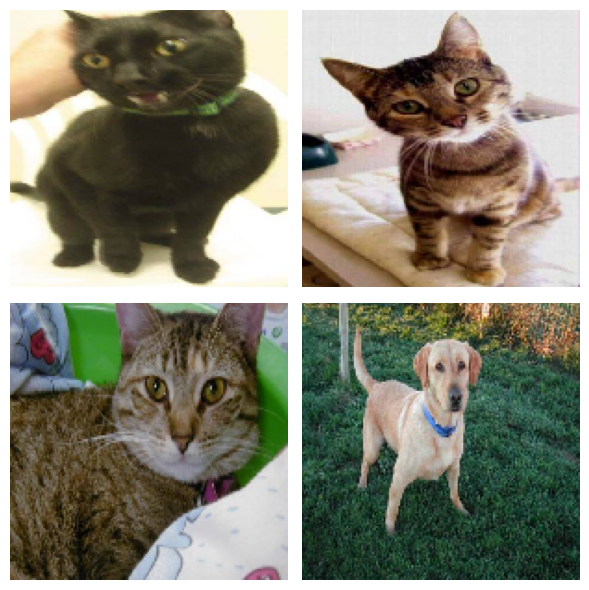

In [35]:
plotImages(sample_training_images[:4])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it thatr is activated by a `relu` activation function. The model outputs class probabilities based on binary classification by the `sigmoid` activation function.

In [36]:
model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
        ])

### Compile the model

For this lab, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [38]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,641,441 (40.59 MB)

 Trainable params: 10,641,441 (40.59 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Use the `fit` method of the `ImageDataGenerator` class to train the network.

In [39]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - accuracy: 0.4930 - loss: 1.1450 - val_accuracy: 0.6161 - val_loss: 0.6842
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5703 - loss: 0.6855 - val_accuracy: 0.6339 - val_loss: 0.6808
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 714ms/step - accuracy: 0.6078 - loss: 0.6727 - val_accuracy: 0.6562 - val_loss: 0.6301
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.6719 - loss: 0.6333 - val_accuracy: 0.5804 - val_loss: 0.6480
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 900ms/step - accuracy: 0.6433 - loss: 0.6205 - val_accuracy: 0.6429 - val_loss: 0.6110
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6875 - loss: 0.6205 - val_accuracy: 0.6138 - val_loss: 0.6385
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6801 - loss: 0.5917 - val_accuracy: 0.6830 - val_loss: 0.6022
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7344 - loss: 0.5297 - val_accuracy: 0.

### Visualize training results

Now visualize the results after training the network.

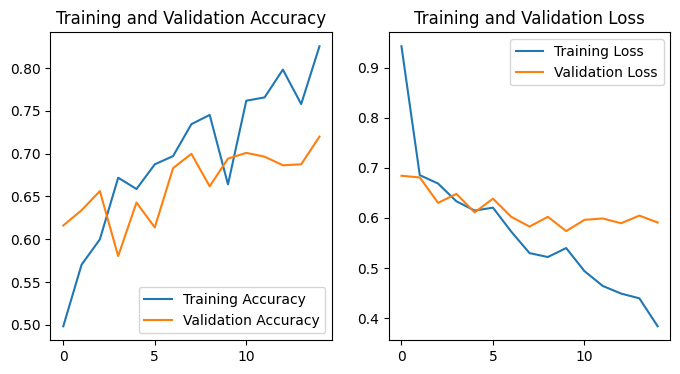

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

Let's look at what went wrong and try to increase overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this lab, you'll use *data augmentation* and add *dropout* to our model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [41]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [42]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [43]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

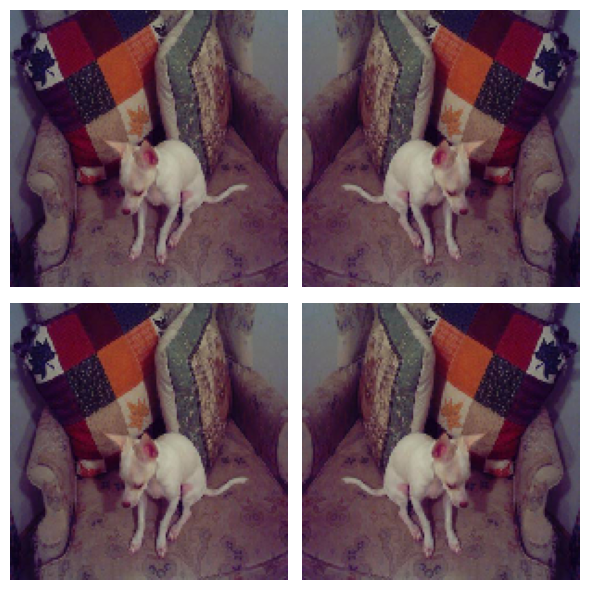

In [44]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [45]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [46]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


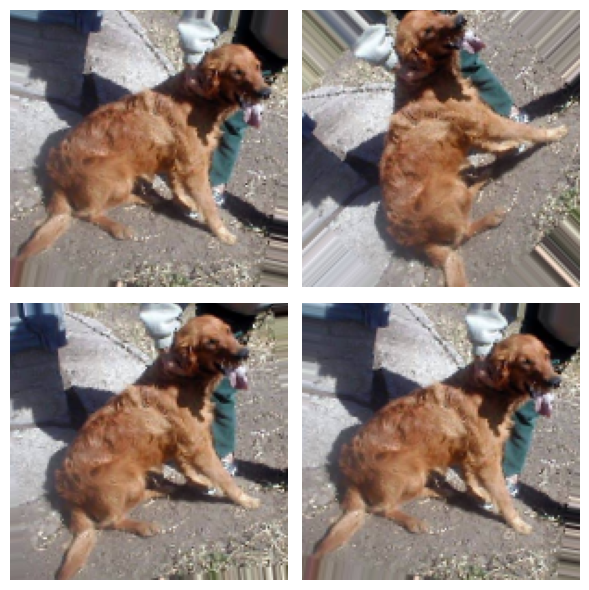

In [47]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [48]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [49]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


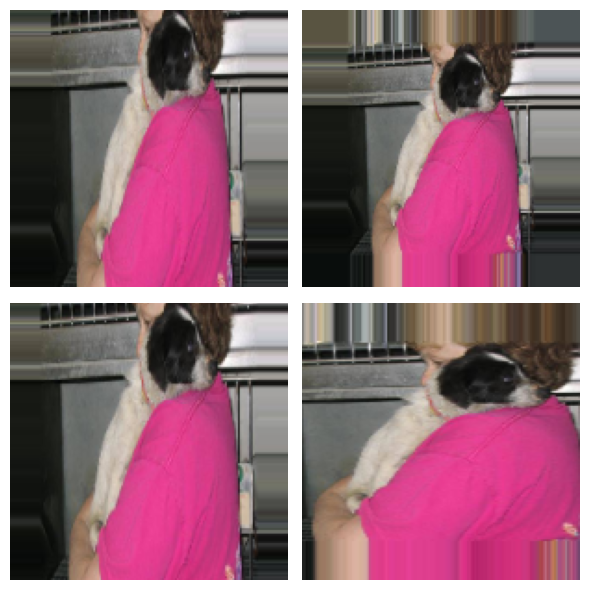

In [50]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations. Here, you applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [51]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [52]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

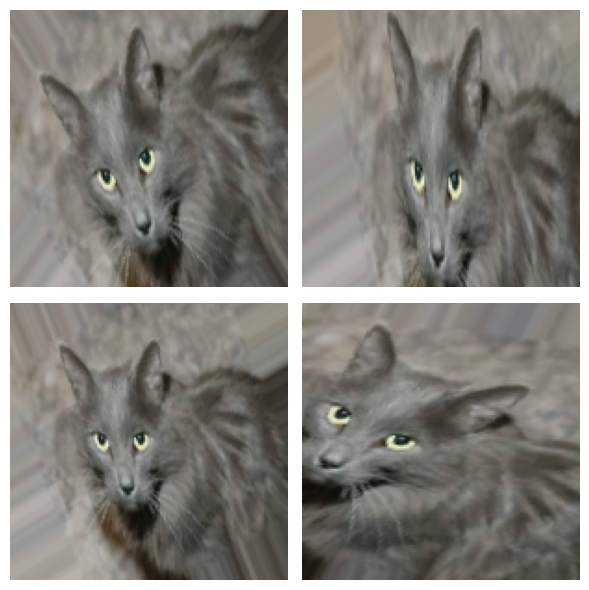

In [53]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [54]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [55]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this lab

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Here, you apply dropout to first and last max pool layers and to a fully connected layer that has 512 output units. 30% of the first and last max pool layer, and 10% of fully connected layer output units, are randomly set to zero during each training epoch.

In [56]:
model_new = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [57]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,327,937 (81.36 MB)

 Trainable params: 21,327,937 (81.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [58]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4995 - loss: 2.3614 - val_accuracy: 0.5078 - val_loss: 0.6931
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.4766 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.6931
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 949ms/step - accuracy: 0.4923 - loss: 0.6932 - val_accuracy: 0.5067 - val_loss: 0.6931
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5312 - loss: 0.6929 - val_accuracy: 0.5134 - val_loss: 0.6931
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5203 - loss: 0.6929 - val_accuracy: 0.4978 - val_loss: 0.6923
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5312 - loss: 0.6898 - val_accuracy: 0.4967 - val_loss: 0.6923
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5389 - loss: 0.6918 - val_accuracy: 0.5446 - val_loss: 0.6924
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5234 - loss: 0.6907 - val_accuracy: 0.5536 

### Visualize the performance of the model

Visualize the performance of a new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

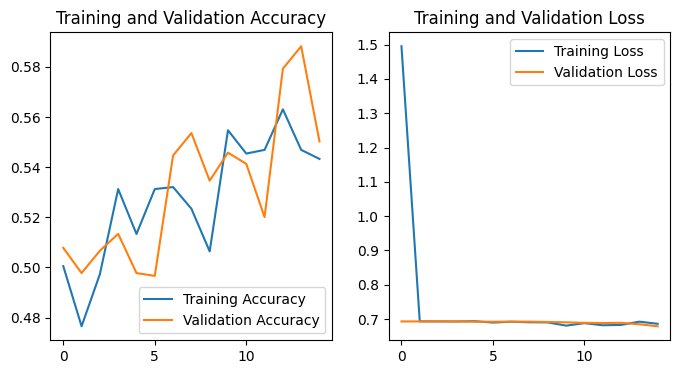

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
This image is 37.13% cat and 62.87% dog.


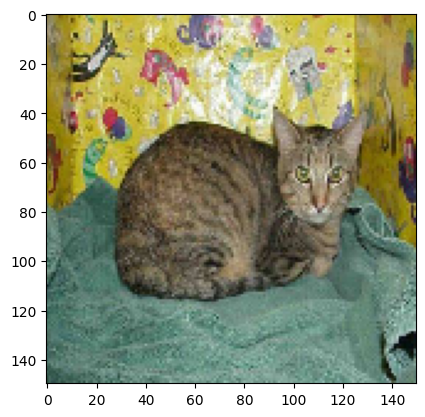

In [60]:
import keras
from keras import layers

img_array, _ = next(val_data_gen)
plt.imshow(img_array[0])

predictions = model_new.predict(img_array)
score = float(tf.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

## Calculate Confusion Matrix

The figure above can also be displayed using a confusion matrix as shown below:

<img src="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/confusion_matrix.png">


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer confusion matrix visualization

def subsampled_generator(original_gen, subsample_size):
    num_batches = max(1, subsample_size // original_gen.batch_size)  # Ensure at least one batch
    for _ in range(num_batches):
        yield next(original_gen)

# Assuming `val_data_gen` and `model_new` are already defined

# Initialize lists to hold all predictions and true labels
all_predictions = []
all_probabilities = []
all_true_labels = []

for img_batch, label_batch in subsampled_generator(val_data_gen, 1000):  # Assuming you want to process 10 images in total
    predictions = model_new.predict(img_batch)
    # Store binary predictions and true labels for each batch
    all_predictions.extend([1 if pred > 0.5 else 0 for pred in predictions.flatten()])
    all_probabilities.extend(predictions.flatten())
    all_true_labels.extend(label_batch.flatten())  # Ensure label_batch is flattened in case it's not

# Ensure all_predictions and all_true_labels are of compatible shapes for confusion_matrix calculation
# Convert lists to numpy arrays for compatibility with sklearn functions
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_true_labels = np.array(all_true_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


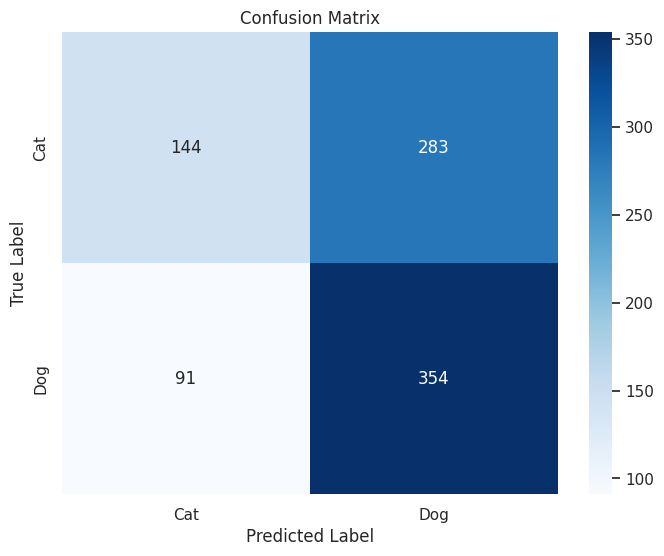

In [62]:
# Compute the confusion matrix using aggregated predictions and true labels
cm = confusion_matrix(all_true_labels, all_predictions)

# Plotting the confusion matrix
sns.set()  # Use seaborn's default style
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Calculate Metrics
This code snippet calculates and prints out several key classification metrics derived from the confusion matrix.

These four groups can be represented in the following figure

<img src="https://miro.medium.com/max/407/1*2WBrkJP8qKO3DDG7Lvg0hg.png">

Using TP, FP, FN and TN, we can calculate some metrics: sensitivity (or recall), specificity, and precision.

**Sensitivity** is a measure of how well a test can **identify true positives**. Sensitivity can also be referred to as the **recall**, hit rate, or **true positive rate**. It is the percentage, or proportion, of true positives out of all the samples that have the condition (true positives and false negatives). It can be seen as "*how sure you are that you are not missing any positives*".

**Specificity** is a measure of how well a test can **identify true negatives**. Specificity is also referred to as selectivity or **true negative rate**, and it is the percentage, or proportion, of the true negatives out of all the samples that do not have the condition (true negatives and false positives).

**Precision** is intuitively the ability of the classifier not to label as positive a sample that is negative. Precision can also be referred as positive predictive values (PPV). It is the proportions of positive results that are true positive. Precision can be seen as "*how sure you are of your true positives*".

These metrics provide a comprehensive view of your model's performance, beyond just accuracy, highlighting its strengths and weaknesses in different areas.

In [63]:
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)  # Also known as True Negative Rate
f1_score = 2 * (precision * recall) / (precision + recall)

# Negative Predictive Value
npv = TN / (TN + FN)

# False Positive Rate
fpr = FP / (FP + TN)

# False Negative Rate
fnr = FN / (TP + FN)

# Positive Likelihood Ratio
plr = recall / fpr

# Negative Likelihood Ratio
nlr = fnr / specificity

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"NPV: {npv:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"PLR: {plr:.4f}")
print(f"NLR: {nlr:.4f}")


Accuracy: 0.5711
Precision: 0.5557
Recall/Sensitivity: 0.7955
Specificity: 0.3372
F1-Score: 0.6543
NPV: 0.6128
FPR: 0.6628
FNR: 0.2045
PLR: 1.2003
NLR: 0.6064


# ROC curve
When making a prediction for a binary or two-class classification problem, the two types of error that we could make are: false positive error and false negative error. By predicting probabilities and calibrating a threshold, a balance of these two errors can be stablished.

A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve.

[`roc_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) computes Receiver operating characteristic (ROC). Note that this implementation is restricted to the binary classification task.

It is a plot of the **false positive rate** (x-axis) versus the **true positive rate** (y-axis) for a number of different candidate threshold values between 0.0 and 1.0.

- The true positive rate is also referred to as sensitivity.
- The false positive rate is also referred to as the inverted specificity (1 - specificity)

An ROC space is defined by FPR and TPR as x and y axes, respectively, which depicts relative trade-offs between true positive (benefits) and false positive (costs). Since TPR is equivalent to sensitivity and FPR is equal to 1 − specificity, the ROC graph is sometimes called the sensitivity vs (1 − specificity) plot.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Roc-draft-xkcd-style.svg/500px-Roc-draft-xkcd-style.svg.png">

Some notes from the figure shown previously:

- The best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives).

- A random guess would give a point along a diagonal line (the so-called line of no-discrimination) from the left bottom to the top right corners (regardless of the positive and negative base rates).

- The diagonal divides the ROC space.
 - Points above the diagonal represent good classification results (better than random).
 - Points below the line represent bad results (worse than random). Note that the output of a consistently bad predictor could simply be inverted to obtain a good predictor.

In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(all_true_labels, all_probabilities)
print(roc_auc_score(all_true_labels, all_probabilities))

0.6384285451148592


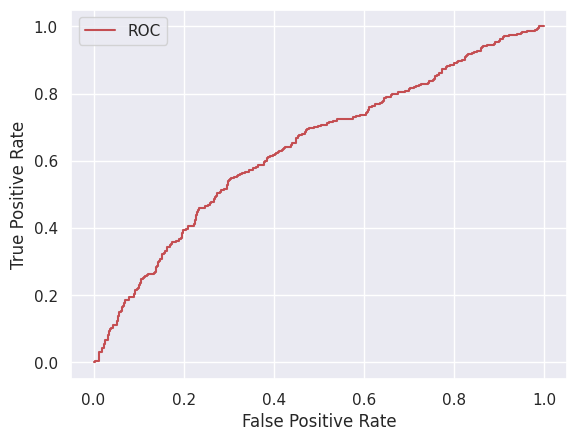

In [65]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr,'r-',label = 'ROC')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Precision-Recall Curve
The Precision-Recall curve (PRC) shows the trade-off between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

In [66]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(all_true_labels, all_probabilities)

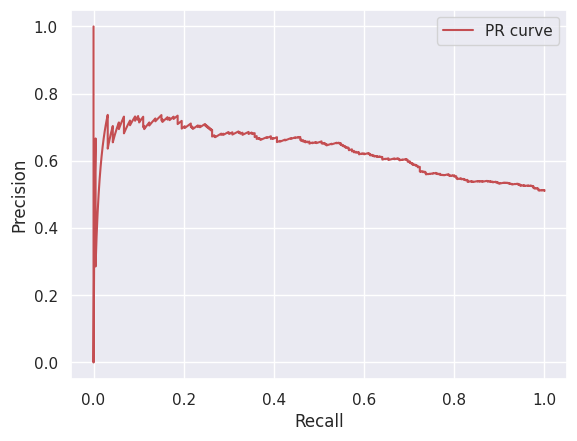

In [67]:
import matplotlib.pyplot as plt

plt.plot(recall, precision, 'r-',label = 'PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()